In [1]:
import torch
import torchvision.transforms as transforms
from utils import *
from models import *

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
test_transform = transforms.Compose([transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])
invertTransform = transforms.Compose([
                                transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
# test_transform = transforms.Compose([transforms.ToTensor()
# ])

test_data = torchvision.datasets.CIFAR10('data/', download=True, train=False, transform=test_transform)
test_dataloader = torch.utils.data.DataLoader(test_data,
                                          batch_size=4096, # just for test accuracy
                                          shuffle=True)

cifar_labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

Files already downloaded and verified


In [10]:
model = ResNet('18').to(device)
model.load_state_dict(torch.load('models/resnet18_l2eps=10steps=7/24')) # 20 omg
model.eval()
print()

Using cache found in C:\Users\Oliver/.cache\torch\hub\pytorch_vision_v0.6.0


In [5]:
# test_acc = accuracy(model, test_dataloader, device)
# fgsm_acc = fgsm_accuracy(model, test_dataloader, device)
# pgd_acc = pgd_accuracy(model, test_dataloader, device, eps=10, steps=3, alpha=0.1)
# print('Normal Test Accuray:', test_acc)
# print('FGSM Test Accuracy:', fgsm_acc)
# print('PGD Test Accuracy:', pgd_acc)

In [6]:
it = iter(test_dataloader)
i, l = it.next()
images, labels = i[0:2].to(device), l[0:2].view(2).to(device)
image, label = images[0], labels[0].view(1)


In [7]:
# this cell exists because of the most annoying bug ever:
# the loss for pgd updates needed to not be averaged so that each input
# was worked on independently of the batch size

# display_im(images[0].cpu())
# print(cifar_labels[labels[0].item()])
# print(cifar_labels[torch.argmax(model(images[0].view(-1,3,32,32))).item()])
# print(torch.min(images[0]), torch.max(images[0]))
# adv = pgd(images.view(1000,3,32,32), labels, model, stepsize=2.5 * 100 / 7, eps=100, steps=7, constraint='l_2')[0]
# print(torch.min(adv), torch.max(adv))
# # adv = fgsm(image.view(1, 3, 32, 32), label, model, eps=.2)
# # print(adv.shape)
# print(torch.min(image - adv), torch.max(image - adv))
# print(cifar_labels[torch.argmax(model(adv.view(1, 3,32,32))).item()])
# display_im(adv.view(3,32,32).cpu())
# display_im((image - adv).view(3, 32, 32).cpu())

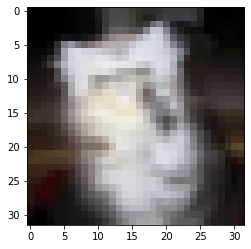

cat
dog
tensor(-2.1179, device='cuda:0') tensor(2.3786, device='cuda:0')
tensor(-2.1951, device='cuda:0') tensor(2.4723, device='cuda:0')
tensor(-0.5320, device='cuda:0') tensor(0.5222, device='cuda:0')
dog

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


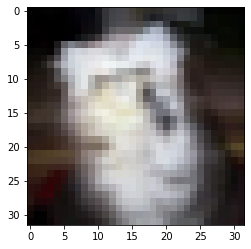

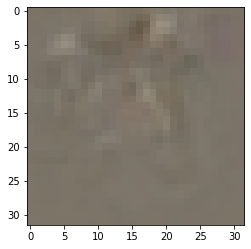

In [8]:
display_im(image.cpu())
print(cifar_labels[label.item()])
print(cifar_labels[torch.argmax(model(image.view(-1,3,32,32))).item()])
print(torch.min(image), torch.max(image))
adv = pgd(image.view(1,3,32,32), label, model, stepsize=2.5 * 10 / 7, eps=10, steps=7, constraint='l_2')
# adv = pgd(image.view(1,3,32,32), label, model, stepsize=.015, eps=.6, steps=40, constraint='l_inf')
# adv = pgd(image.view(1,3,32,32), label, model, stepsize=0.1, eps=.5, steps=7, constraint='l_inf')
print(torch.min(adv), torch.max(adv))
# adv = fgsm(image.view(1, 3, 32, 32), label, model, eps=.2)
# adv = pgd_attack(image.view(3,32,32), 5, model, stepsize=1, eps=60, steps=80, constraint='l_2')
# print(torch.max(image - adv))
# print(adv.shape)
print(torch.min(image - adv), torch.max(image - adv))
print(cifar_labels[torch.argmax(model(adv)).item()])
display_im(adv.view(3,32,32).cpu())
display_im((image - adv).view(3, 32, 32).cpu())

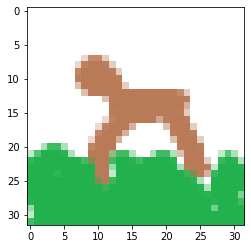

torch.Size([1, 3, 32, 32]) torch.Size([1])


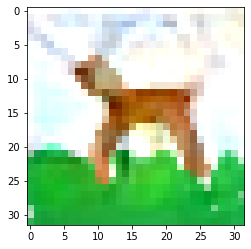

bird


In [17]:
import imageio
image = torch.Tensor(imageio.imread('deer.png')).permute(2, 0, 1).to(device) / 255.
# print(image.shape)
plt.imshow(image.permute(1, 2, 0).cpu())
plt.show()
label = torch.Tensor([6]).cuda().long()
# adv = pgd(image.view(1,3,32,32), label, model, stepsize=1, eps=60, steps=80, constraint='l_2')
# adv = pgd(image.view(1,3,32,32), label, model, stepsize=.015, eps=.6, steps=40, constraint='l_inf')
# adv = pgd(image.view(1,3,32,32), label, model, stepsize=.03, eps=.1, steps=5, constraint='l_inf')

# adv = fgsm(image.view(1, 3, 32, 32), label, model, eps=0.2)
adv = pgd_attack(image.view(3,32,32), 4, model, stepsize=2.5 * 1000 / 100, eps=1000, steps=100, constraint='l_2')
plt.imshow(adv.cpu().view(3, 32, 32).permute(1, 2, 0))
plt.show()
print(cifar_labels[torch.argmax(model(adv.view(1, 3, 32, 32))).item()])
